In [1]:
import numpy as np
import gpflow

#It's the old package without your updates... can change after sync repository
#As such, will need to pull "master" for this to work
from thermoextrap.xtrapy import models
from thermoextrap.xtrapy import xpan_beta
from thermoextrap.xtrapy import xpan_vol
from thermoextrap.xtrapy import xpan_GPR
from thermoextrap import ig

import matplotlib.pyplot as plt

# Ideal gas comparison

In [2]:
from importlib import reload
reload(xpan_GPR)

<module 'thermoextrap.xtrapy.xpan_GPR' from '/Users/wpk/Documents/python/projects/thermodynamic-extrapolation/thermoextrap/xtrapy/xpan_GPR.py'>

# looking at multiple predictions

In [3]:
# %matplotlib notebook
def get_aveX1(beta, V=1):
    return ig_model.avgX(beta_vals, V)

def get_aveX2(beta, V=1):
    return (-(V**2*beta**2 + 2*V*beta - 2*np.exp(V*beta) + 2)/(beta**2*(np.exp(V*beta) - 1)))

def get_aveX3(beta, V=1):
    return (-(V**3*beta**3 + 3*V**2*beta**2 + 6*V*beta - 6*np.exp(V*beta) + 6)/(beta**3*(np.exp(V*beta) - 1)))

get_aves = [get_aveX1, get_aveX2, get_aveX3]

In [4]:
# both <x> and <x**2>
ig_model = ig.IGmodel()
beta_ref = np.array([0.1, 9.1])

nconfig = 10_000

ig_states = []
for b in beta_ref:
    # this is for the <x> over particles.  Doesn't work
#     xdata, udata = ig_model.genData(b, nConfigs=10000)
#     data = xpan_beta.factory_data(uv=udata, xv=xdata[:, None], order=3, central=True)
    # this should work?
    all_configs = ig_model.sampleX(b, nconfig * ig_model.nP).reshape(nconfig, ig_model.nP)    
    xdata = (all_configs).mean(axis=1)
    xdata2 = (all_configs**2).mean(axis=1)
    xdata3 = (all_configs**3).mean(axis=1)
    udata = all_configs.sum(axis=1)
    data = xpan_beta.factory_data(uv=udata, 
                                  xv=np.stack((xdata, xdata2, xdata3), axis=-1), 
                                  order=1, central=True)
    
    ig_states.append(xpan_beta.factory_extrapmodel(b, data))

In [5]:
ig_gpr = xpan_GPR.factory_rbf_gprmodel(ig_states)
ig_interp = models.InterpModel(ig_states)

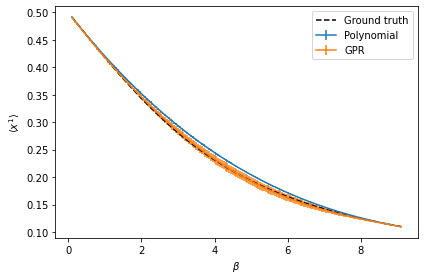

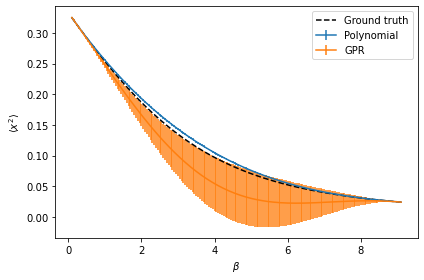

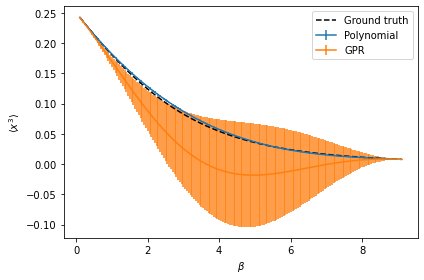

In [7]:
beta_vals = np.arange(0.1, 9.15, 0.05)
gpr_mu, gpr_std = ig_gpr.predict(beta_vals)
interp_mu = ig_interp.predict(beta_vals)
interp_std = ig_interp.resample(nrep=100).predict(beta_vals).std('rep')

for val in range(3):
    fig, ax = plt.subplots()

    ax.plot(beta_vals, get_aves[val](beta_vals), 'k--', label='Ground truth')
    ax.errorbar(beta_vals, np.squeeze(interp_mu.sel(val=val)), yerr=np.squeeze(interp_std.sel(val=val)), 
                marker='', label='Polynomial')
    ax.errorbar(beta_vals, np.squeeze(gpr_mu.sel(val=val)), yerr=np.squeeze(gpr_std.sel(val=val)), 
                marker='', label='GPR')

    ax.legend()

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\langle x^{{{}}} \rangle$'.format(val+1))

    fig.tight_layout()



# New API

In [5]:
import xarray as xr

In [6]:
# both <x> and <x**2>
ig_model = ig.IGmodel()
beta_ref = np.array([0.1, 9.1])

nconfig = 10_000
exponent = xr.DataArray([1,2,3], dims='val', coords={'val': ['x','x2','x3']})


ig_states = []
for b in beta_ref:
    # this is for the <x> over particles.  Doesn't work
#     xdata, udata = ig_model.genData(b, nConfigs=10000)
#     data = xpan_beta.factory_data(uv=udata, xv=xdata[:, None], order=3, central=True)
    # this should work?
    all_configs = ig_model.sampleX(b, nconfig * ig_model.nP).reshape(nconfig, ig_model.nP)    
    all_configs = xr.DataArray(all_configs, dims=['rec','part'])
    
    xv = (all_configs ** exponent).mean('part')
    uv = all_configs.sum('part')
    data = xpan_beta.DataCentralMomentsVals(uv, xv, order=1)
    state = xpan_beta.factory_extrapmodel(beta=b, data=data)
    ig_states.append(state)
    

In [7]:
import thermoextrap.xtrapy.xpan_gpr_stack as xpan_gpr
reload(xpan_gpr)

<module 'thermoextrap.xtrapy.xpan_gpr_stack' from '/Users/wpk/Documents/python/projects/thermodynamic-extrapolation/thermoextrap/xtrapy/xpan_gpr_stack.py'>

In [8]:
nrec = len(ig_states[0].data)
nrep = 100
indices = [np.random.choice(nrec, (nrep, nrec), replace=True) for _ in ig_states]


In [11]:
# breaking this down a bit:
gp_data = xpan_gpr.GPRData(ig_states,
                            # name of dimension to calculate mean/var along
                            reduce_dim='rep',
                            # name of "x" dimensions
                            x_dims=['beta', 'order'],
                            # name of statistics dimension
                            stats_dim='stats'
                          ).resample(
                                     indices=indices,
                                     # note: this name needs to match reduce_dim above
                                     rep_dim='rep')

In [12]:
# creating a GPRModel
gp_model = xpan_gpr.factory_gprmodel(gp_data)

In [13]:
# explicitly train
# There is not 'autoTrain'
# I think for this, that should be the default
gp_model.train()

In [9]:
# alternative data models
# this only takes derivative information
derivs = (
    # could be any stateCollection, so just use the base StateCollection
    models.StateCollection(ig_states)
    .resample(indices=indices, rep_dim='rep')
    .map_concat('derivs')
)

gp_data2 = xpan_gpr.StackedDerivatives.from_derivs(derivs, 
                                                 x_dims=['beta','order'], 
                                                 reduce_dim=['rep'],
                                                )

gp_model2 = xpan_gpr.factory_gprmodel(gp_data2)

In [10]:
gp_model2.train()

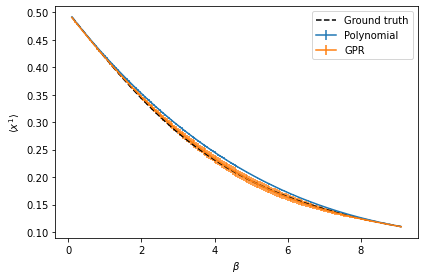

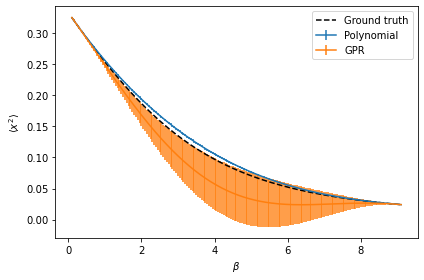

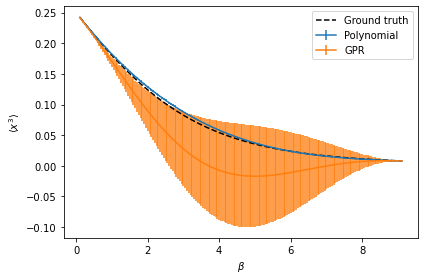

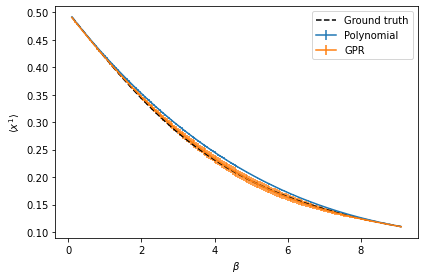

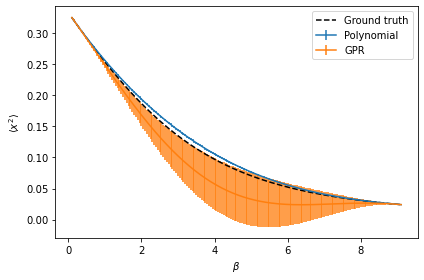

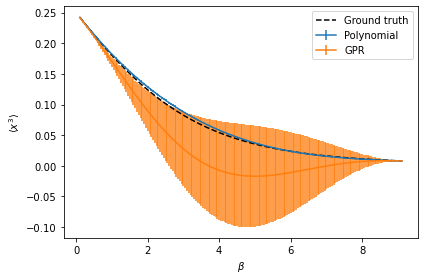

In [14]:
beta_vals = np.arange(0.1, 9.15, 0.05)
for gpm in [gp_model, gp_model2]:
    out = gpm.predict(beta_vals, unstack=True)

    gpr_mu = out.sel(stats='mean')
    gpr_std = np.sqrt(out.sel(stats='var'))

    ig_interp = models.InterpModel(gp_data.states)

    out = ig_interp.predict(beta_vals)

    interp_mu = out.mean('rep')
    interp_std = out.std('rep')

    for val in range(3):
        fig, ax = plt.subplots()

        ax.plot(beta_vals, get_aves[val](beta_vals), 'k--', label='Ground truth')
        ax.errorbar(beta_vals, np.squeeze(interp_mu.isel(val=val)), yerr=np.squeeze(interp_std.isel(val=val)), 
                    marker='', label='Polynomial')
        ax.errorbar(beta_vals, np.squeeze(gpr_mu.isel(val=val)), yerr=np.squeeze(gpr_std.isel(val=val)), 
                    marker='', label='GPR')

        ax.legend()

        ax.set_xlabel(r'$\beta$')
        ax.set_ylabel(r'$\langle x^{{{}}} \rangle$'.format(val+1))

        fig.tight_layout()

In [73]:
gp_model.gp_params(1)['gp']

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.348793091883529                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.052358255844089                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────

In [69]:
gp_model.gp_params(1)['gp']

╒════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════════════════════╕
│ name           │ class     │ transform      │ prior   │ trainable   │ shape     │ dtype   │ value                                                │
╞════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.var │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 0.348793091883529                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.l   │ Parameter │ Softplus       │         │ True        │ ()        │ float64 │ 9.052358255844089                                    │
├────────────────┼───────────┼────────────────┼─────────┼─────────────┼───────────┼─────────┼─────────────